In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, rfft, fftfreq, rfftfreq
import os, re
# os.chdir("/home")


/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction


---
Reading data from three different flights (with the first file containing concatenated data from two flights)


In [41]:
data_15 = pd.read_csv('data/gyro_acc_lot_03_15.csv')
data_35 = pd.read_csv('data/gryo_acc_lot_10_35.csv')


In [22]:
data_good_1 = pd.read_csv('data_new/lot_1_all_good.csv')
data_good_2 = pd.read_csv('data_new/lot_2_all_good.csv')
data_bad_1 = pd.read_csv('data_new/lot_3_not_good.csv')
data_bad_2 = pd.read_csv('data_new/lot_4_not_good.csv')

In [14]:
data_good_1.head()

,timestamp(ms),IMU[0].GyrX,IMU[0].GyrY,IMU[0].GyrZ,sqrt(IMU[0].AccX**2+IMU[0].AccY**2+IMU[0].AccZ**2)
0,272806.312,0.000089,0.000061,-0.000014,9.822422
1,272906.312,-0.000149,0.000900,0.000360,9.822154
2,273006.312,0.000437,-0.000142,0.000615,9.817519
3,273106.312,0.000423,0.000118,0.000706,9.824338
4,273206.312,0.000809,-0.000114,-0.000279,9.825777


In [16]:
data_good_2.head()

,timestamp(ms),IMU[0].GyrX,IMU[0].GyrY,IMU[0].GyrZ,sqrt(IMU[0].AccX**2+IMU[0].AccY**2+IMU[0].AccZ**2)
0,272806.312,0.000089,0.000061,-0.000014,9.822422
1,272906.312,-0.000149,0.000900,0.000360,9.822154
2,273006.312,0.000437,-0.000142,0.000615,9.817519
3,273106.312,0.000423,0.000118,0.000706,9.824338
4,273206.312,0.000809,-0.000114,-0.000279,9.825777


In [ ]:
data_good_1.head()

In [ ]:
data_good_1.head()

---
Verifying the obtained data; this file contains data from a flight with healthy rotor blades and one with a 1.5 cm damage.

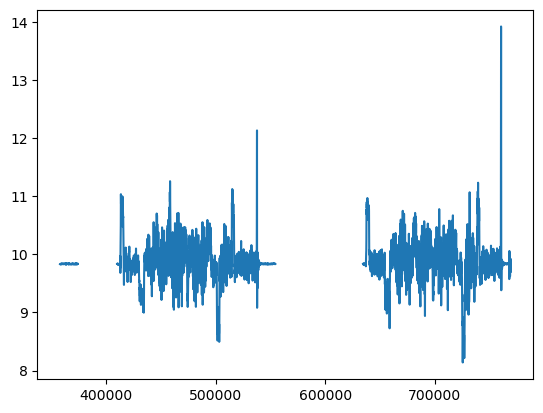

In [23]:
plt.plot(data_good_1['timestamp(ms)'],data_good_1['sqrt(IMU[0].AccX**2+IMU[0].AccY**2+IMU[0].AccZ**2)'])
plt.show()

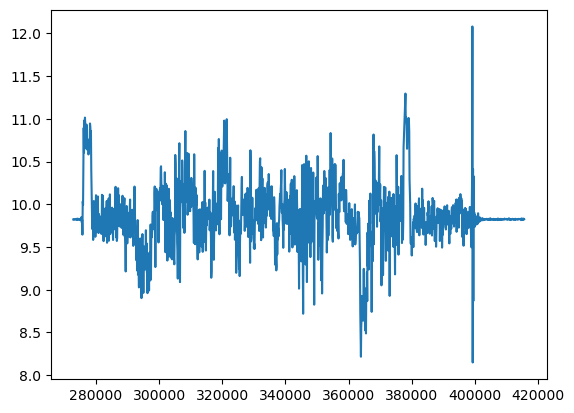

In [24]:
plt.plot(data_good_2['timestamp(ms)'],data_good_2['sqrt(IMU[0].AccX**2+IMU[0].AccY**2+IMU[0].AccZ**2)'])
plt.show()

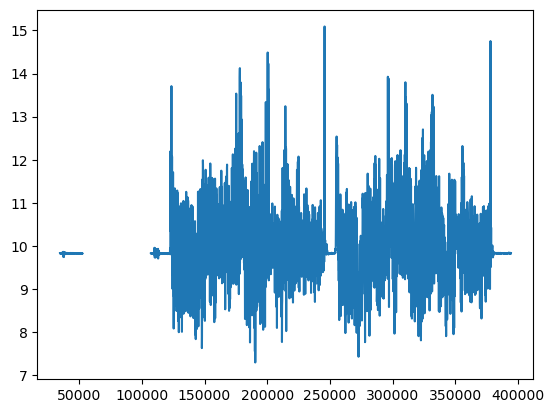

In [25]:
plt.plot(data_bad_2['timestamp(ms)'],data_bad_2['sqrt(IMU[0].AccX**2+IMU[0].AccY**2+IMU[0].AccZ**2)'])
plt.show()

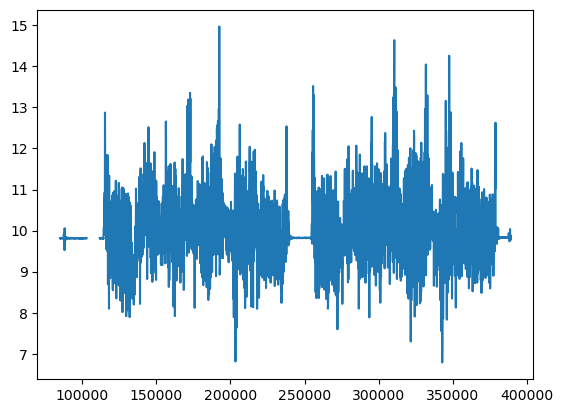

In [26]:
plt.plot(data_bad_1['timestamp(ms)'],data_bad_1['sqrt(IMU[0].AccX**2+IMU[0].AccY**2+IMU[0].AccZ**2)'])
plt.show()

In [44]:
def get_first_last_none_index(df, column_name):
    column = df[column_name]
    first_none_index = column.index[column.isnull()].min()
    last_none_index = column.index[column.isnull()].max()
    return first_none_index, last_none_index

def split_array(array, segment_size, overlap):
    splitted_segments = []
    i = 0
    while i < len(array):
        if len(array[i:i+segment_size]) == segment_size:
            splitted_segments.append(array[i:i+segment_size])
        i += segment_size - overlap
    return splitted_segments

def split_aggregation(array,first_segment,agg):
    splitted_segments = []
    i = 0
    while first_segment+agg*i < len(array):
        splitted_segments.append(array[:first_segment+agg*i])
        i += 1
    return splitted_segments

def get_acc(arr1,arr2,arr3):
    sum_of_squares = np.square(arr1) + np.square(arr2) + np.square(arr3)
    result = np.sqrt(sum_of_squares)
    return result

def normalization(data):
    min_data = min(data)
    diff_data = max(data) - min_data
    return [(x-min_data)/diff_data for x in data]

def FFT_data(data_array,df=True):
    data_dict = {}
    signal_size = 500
    sample_rate = 1000
    skip_unit_jump = 10 #on the first values is noise as unit jump, so we skip them
    fft_freq = rfftfreq(signal_size, d=1/sample_rate)

    data_dict['Frequencies'] = fft_freq[skip_unit_jump:]
    for index,data in enumerate(data_array):
        fft_val = abs(rfft(data,n=signal_size))
        data_dict[f'Sample {index+1}'] = normalization(fft_val[skip_unit_jump:])
    if df:
        return pd.DataFrame.from_dict(data_dict)
    else:
        return data_dict


---

In [45]:
# Get the first and last indices for data_15
first, second = get_first_last_none_index(data_15, 'IMU[0].AccY')

# Calculate time for "healthy" data
time_healthy = data_15['timestamp(ms)'].values[:first] - min(data_15['timestamp(ms)'].values[:first])

# Calculate time for "damaged" data
time_damaged = data_15['timestamp(ms)'].values[second + 1:] - min(data_15['timestamp(ms)'].values[second + 1:])

# Calculate time for "very damaged" data
time_very_damaged = data_35['timestamp(ms)'].values - min(data_35['timestamp(ms)'].values)

# Get accelerometer data for "healthy" state
acc_X_healthy = data_15['IMU[0].AccX'].values[:first]
acc_Y_healthy = data_15['IMU[0].AccY'].values[:first]
acc_Z_healthy = data_15['IMU[0].AccZ'].values[:first]
acc_healthy = get_acc(acc_X_healthy, acc_Y_healthy, acc_Z_healthy)  # 50 210

# Get gyroscope data for "healthy" state
gyro_X_healthy = data_15['degrees(IMU[0].GyrX)'].values[:first]
gyro_Y_healthy = data_15['degrees(IMU[0].GyrY)'].values[:first]
gyro_Z_healthy = data_15['degrees(IMU[0].GyrZ)'].values[:first]
gyro_healthy = get_acc(gyro_X_healthy, gyro_Y_healthy, gyro_Z_healthy)  # 50 210

# Get accelerometer data for "damaged" state
acc_X_damaged = data_15['IMU[0].AccX'].values[second + 1:]
acc_Y_damaged = data_15['IMU[0].AccY'].values[second + 1:]
acc_Z_damaged = data_15['IMU[0].AccZ'].values[second + 1:]
acc_damaged = get_acc(acc_X_damaged, acc_Y_damaged, acc_Z_damaged)  # 50 190

# Get gyroscope data for "damaged" state
gyro_X_damaged = data_15['degrees(IMU[0].GyrX)'].values[second + 1:]
gyro_Y_damaged = data_15['degrees(IMU[0].GyrY)'].values[second + 1:]
gyro_Z_damaged = data_15['degrees(IMU[0].GyrZ)'].values[second + 1:]
gyro_damaged = get_acc(gyro_X_damaged, gyro_Y_damaged, gyro_Z_damaged)  # 50 190

# Get accelerometer data for "very damaged" state
acc_X_very_damaged = data_35['IMU[0].AccX'].values
acc_Y_very_damaged = data_35['IMU[0].AccY'].values
acc_Z_very_damaged = data_35['IMU[0].AccZ'].values

# Get gyroscope data for "very damaged" state
gyro_X_very_damaged = data_35['degrees(IMU[0].GyrX)'].values
gyro_Y_very_damaged = data_35['degrees(IMU[0].GyrY)'].values
gyro_Z_very_damaged = data_35['degrees(IMU[0].GyrZ)'].values

# Calculate accelerometer values for "very damaged" state
acc_very_damaged = get_acc(acc_X_very_damaged, acc_Y_very_damaged, acc_Z_very_damaged)  # 5 135

# Calculate gyroscope values for "very damaged" state
gyro_very_damaged = get_acc(gyro_X_very_damaged, gyro_Y_very_damaged, gyro_Z_very_damaged)  # 5 135


In [46]:
start = 50
stop = 150

In [ ]:
# Get the first and last indices for data_15
first, second = get_first_last_none_index(data_15, 'IMU[0].AccY')

# Calculate time for "healthy" data
time_healthy = data_15['timestamp(ms)'].values[:first] - min(data_15['timestamp(ms)'].values[:first])

# Calculate time for "damaged" data
time_damaged = data_15['timestamp(ms)'].values[second + 1:] - min(data_15['timestamp(ms)'].values[second + 1:])

# Calculate time for "very damaged" data
time_very_damaged = data_35['timestamp(ms)'].values - min(data_35['timestamp(ms)'].values)

# Get accelerometer data for "healthy" state
acc_X_healthy = data_15['IMU[0].AccX'].values[:first]
acc_Y_healthy = data_15['IMU[0].AccY'].values[:first]
acc_Z_healthy = data_15['IMU[0].AccZ'].values[:first]
acc_healthy = get_acc(acc_X_healthy, acc_Y_healthy, acc_Z_healthy)  # 50 210

# Get gyroscope data for "healthy" state
gyro_X_healthy = data_15['degrees(IMU[0].GyrX)'].values[:first]
gyro_Y_healthy = data_15['degrees(IMU[0].GyrY)'].values[:first]
gyro_Z_healthy = data_15['degrees(IMU[0].GyrZ)'].values[:first]
gyro_healthy = get_acc(gyro_X_healthy, gyro_Y_healthy, gyro_Z_healthy)  # 50 210

# Get accelerometer data for "damaged" state
acc_X_damaged = data_15['IMU[0].AccX'].values[second + 1:]
acc_Y_damaged = data_15['IMU[0].AccY'].values[second + 1:]
acc_Z_damaged = data_15['IMU[0].AccZ'].values[second + 1:]
acc_damaged = get_acc(acc_X_damaged, acc_Y_damaged, acc_Z_damaged)  # 50 190

# Get gyroscope data for "damaged" state
gyro_X_damaged = data_15['degrees(IMU[0].GyrX)'].values[second + 1:]
gyro_Y_damaged = data_15['degrees(IMU[0].GyrY)'].values[second + 1:]
gyro_Z_damaged = data_15['degrees(IMU[0].GyrZ)'].values[second + 1:]
gyro_damaged = get_acc(gyro_X_damaged, gyro_Y_damaged, gyro_Z_damaged)  # 50 190

# Get accelerometer data for "very damaged" state
acc_X_very_damaged = data_35['IMU[0].AccX'].values
acc_Y_very_damaged = data_35['IMU[0].AccY'].values
acc_Z_very_damaged = data_35['IMU[0].AccZ'].values

# Get gyroscope data for "very damaged" state
gyro_X_very_damaged = data_35['degrees(IMU[0].GyrX)'].values
gyro_Y_very_damaged = data_35['degrees(IMU[0].GyrY)'].values
gyro_Z_very_damaged = data_35['degrees(IMU[0].GyrZ)'].values

# Calculate accelerometer values for "very damaged" state
acc_very_damaged = get_acc(acc_X_very_damaged, acc_Y_very_damaged, acc_Z_very_damaged)  # 5 135

# Calculate gyroscope values for "very damaged" state
gyro_very_damaged = get_acc(gyro_X_very_damaged, gyro_Y_very_damaged, gyro_Z_very_damaged)  # 5 135


---
Comparing acceleration signals after drone takeoff with different rotor blade conditions.

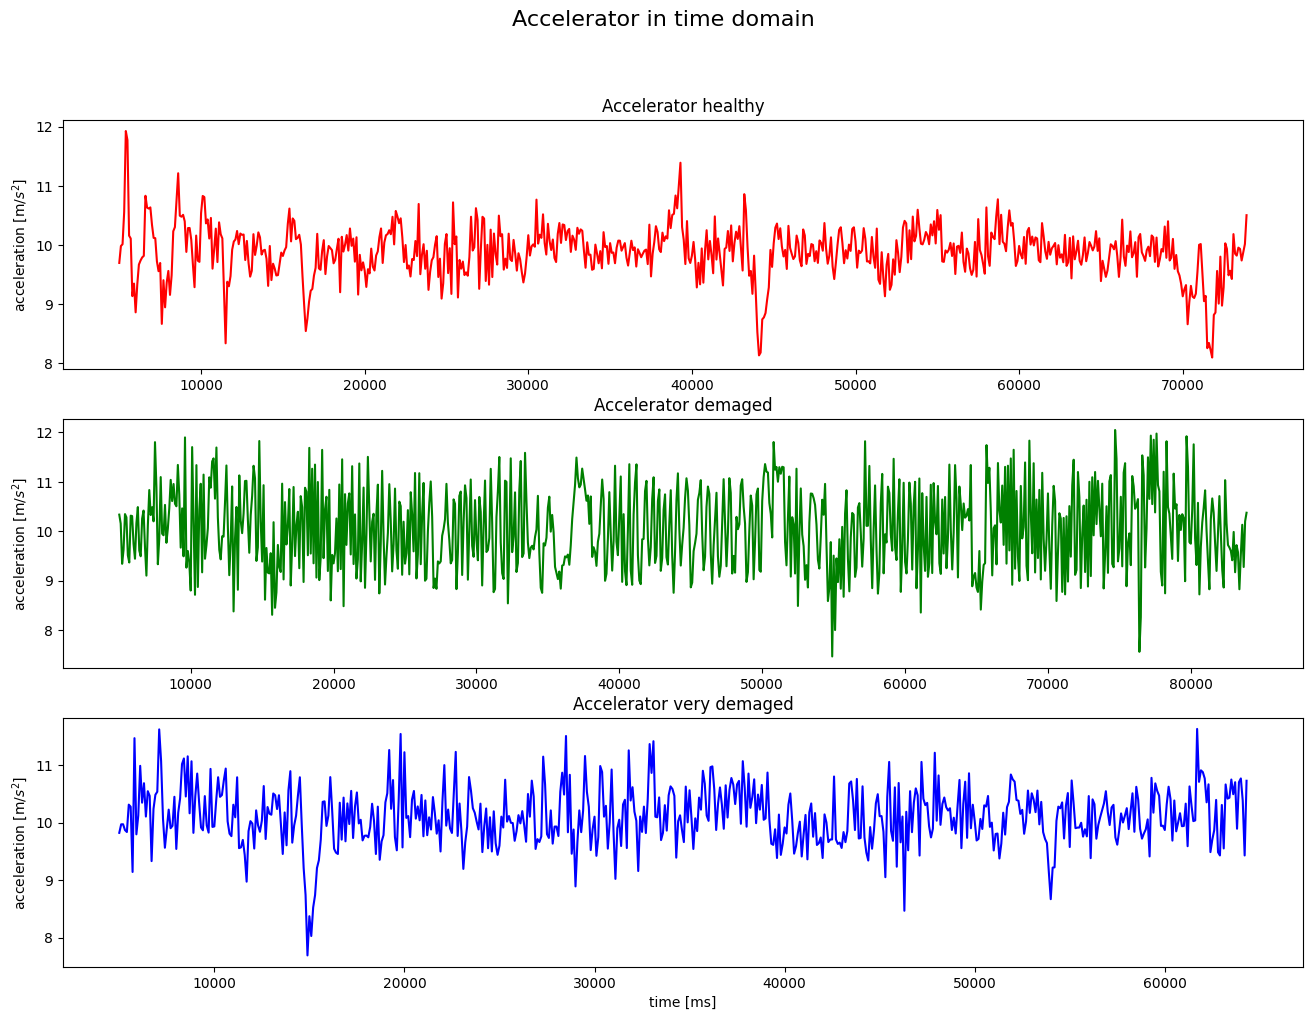

In [70]:
fig,ax = plt.subplots(3,1,figsize=[16,11])


ax[0].set_title('Acceleration')
ax[0].plot(time_healthy[start:len(time_healthy)-210], acc_healthy[start:len(time_healthy)-210], label='Acc_healthy',color='red')
ax[1].plot(time_damaged[start:len(time_damaged)-190], acc_damaged[start:len(time_damaged)-190], label='Acc_damaged',color='green')
ax[2].plot(time_very_damaged[start:len(time_very_damaged)-135], acc_very_damaged[start:len(time_very_damaged)-135], label='Acc_very_damaged',color='blue')

# ax[0].legend()
# ax[1].legend()
# ax[2].legend()
ax[0].set_ylabel(r'acceleration [m/$s^2$]')
ax[1].set_ylabel(r'acceleration [m/$s^2$]')

ax[2].set_ylabel(r'acceleration [m/$s^2$]')
ax[2].set_xlabel('time [ms]')
ax[0].set_title('Accelerator healthy')
ax[1].set_title('Accelerator demaged')
ax[2].set_title('Accelerator very demaged')
fig.suptitle('Accelerator in time domain', fontsize=16)
plt.savefig('photos/data_from_acc_1.png')
plt.show()

In [48]:
acc_healthy_split = split_array(acc_healthy[50:len(acc_healthy)-210],150,125)
acc_damaged_split = split_array(acc_damaged[50:len(acc_damaged)-190],150,125)
acc_very_damaged_split = split_array(acc_very_damaged[50:len(acc_very_damaged)-135],150,125)

In [49]:
columns_h = [f'Sample {x}' for x in range(len(acc_healthy_split))]
columns_d = [f'Sample {x}' for x in range(len(acc_damaged_split))]
columns_vd = [f'Sample {x}' for x in range(len(acc_very_damaged_split))]

In [50]:
data_healthy = pd.DataFrame(acc_healthy_split).T
data_damaged = pd.DataFrame(acc_damaged_split).T
data_very_damaged = pd.DataFrame(acc_very_damaged_split).T
data_healthy.columns = columns_h
data_damaged.columns = columns_d
data_very_damaged.columns = columns_vd

In [51]:
data_healthy.head()

,Sample 0,Sample 1,Sample 2,Sample 3,Sample 4,Sample 5,Sample 6,Sample 7,Sample 8,Sample 9,...,Sample 12,Sample 13,Sample 14,Sample 15,Sample 16,Sample 17,Sample 18,Sample 19,Sample 20,Sample 21
0,9.698080,9.696647,10.539860,10.171881,9.815653,10.082813,9.568929,10.000623,10.185560,10.003679,...,10.032518,9.470084,9.819475,9.724544,10.030857,9.726378,10.063583,10.082548,10.592846,10.438717
1,9.983599,8.667918,10.829459,10.178237,9.908080,9.509679,9.292522,9.602241,9.526098,9.330222,...,9.868690,9.852374,10.052766,10.034888,10.294684,9.896052,9.617883,9.870141,10.258136,9.916890
2,10.014586,9.406136,10.811474,9.746929,9.964858,9.806895,9.592371,9.655449,9.946701,10.260179,...,9.874494,10.049595,9.750120,10.225900,10.363367,9.698494,9.905597,9.542306,10.505762,9.830894
3,10.560446,8.947886,10.365710,10.069560,10.357260,9.984034,9.520640,9.468885,9.174200,9.459368,...,9.693021,10.318812,9.283753,10.103375,10.101467,10.078115,9.866431,9.800592,9.723479,9.680808
4,11.926492,9.368466,10.433258,9.702129,10.616596,9.949000,9.939603,9.763273,10.721262,10.194759,...,9.956798,10.219200,9.699670,10.318978,10.283608,10.035480,9.907905,10.295830,9.715515,9.515890


---
Save accelerometer data in the time domain.

In [52]:
data_healthy.to_csv('data_preprocesed/acc_healthy_samples.csv')
data_damaged.to_csv('data_preprocesed/acc_damaged_samples.csv')
data_very_damaged.to_csv('data_preprocesed/acc_very_damaged_samples.csv')

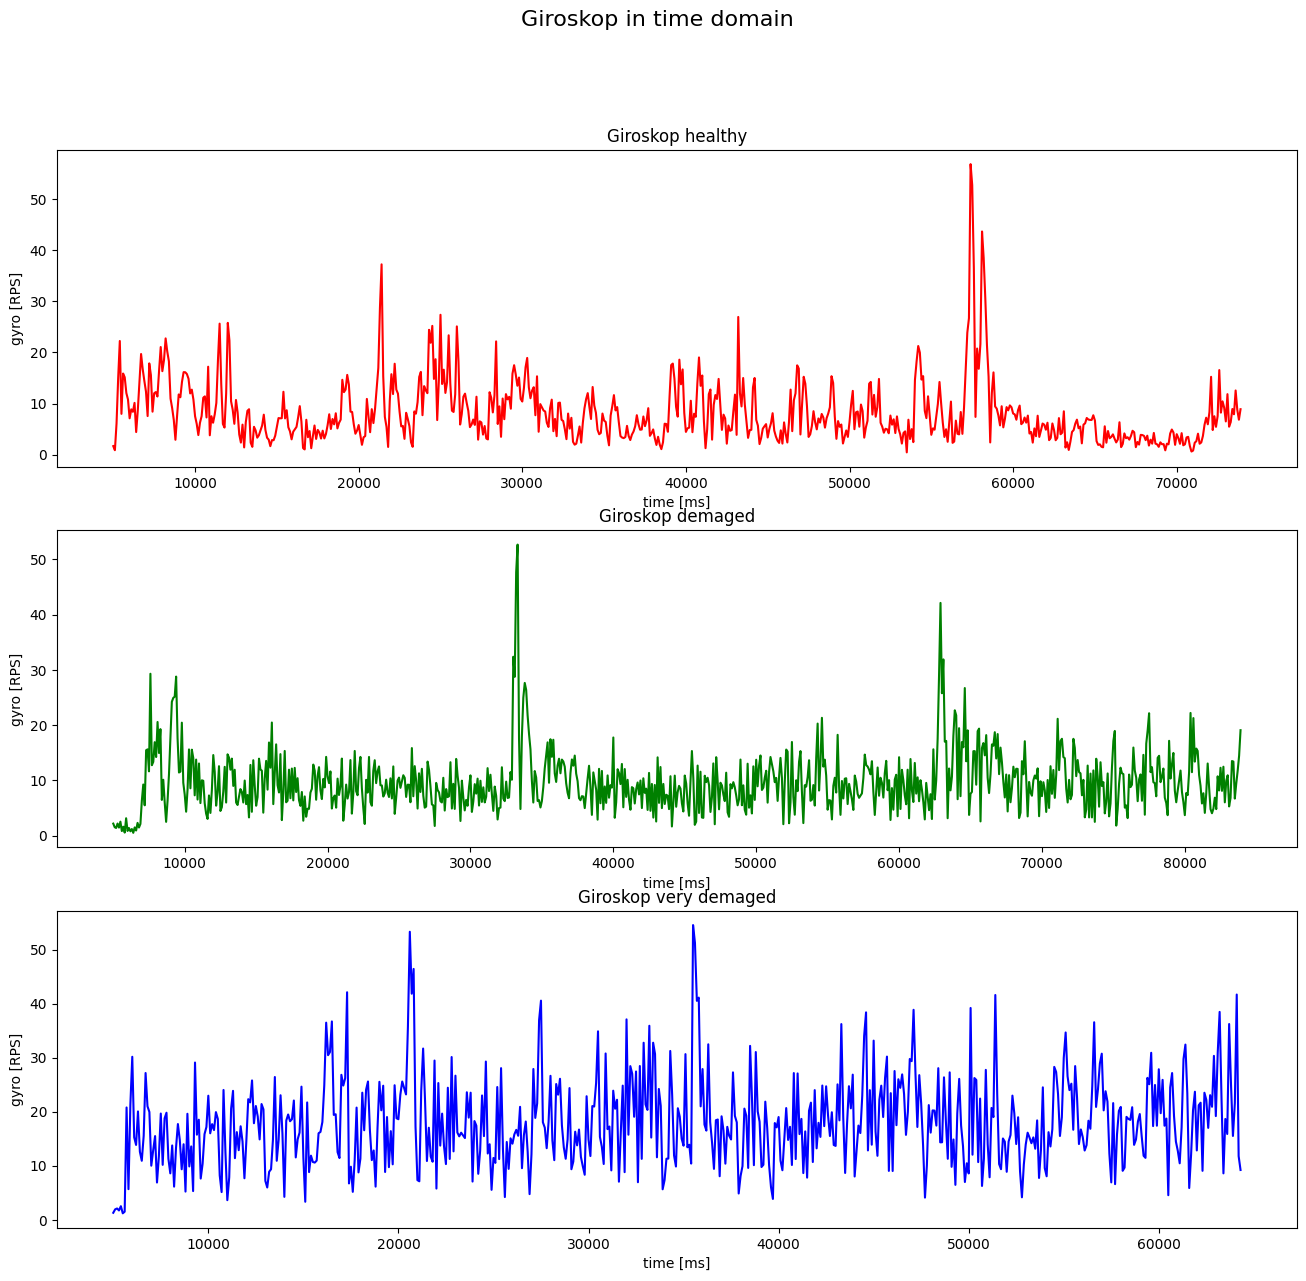

In [72]:
fig,ax = plt.subplots(3,1,figsize=[16,14])

ax[0].plot(time_healthy[50:len(time_healthy)-210], gyro_healthy[50:len(time_healthy)-210], label='gyro_healthy',color='red')
ax[1].plot(time_damaged[50:len(time_damaged)-190], gyro_damaged[50:len(time_damaged)-190], label='gyro_damaged',color='green')
ax[2].plot(time_very_damaged[50:len(time_very_damaged)-135],gyro_very_damaged[50:len(time_very_damaged)-135],label='gyro_very_damaged',color='blue')
ax[0].set_title('Giroskop healthy')
ax[1].set_title('Giroskop demaged')
ax[2].set_title('Giroskop very demaged')
fig.suptitle('Giroskop in time domain', fontsize=16)

ax[0].set_ylabel('gyro [RPS]')
ax[1].set_ylabel('gyro [RPS]')
ax[2].set_ylabel('gyro [RPS]')
ax[0].set_xlabel('time [ms]')
ax[1].set_xlabel('time [ms]')
ax[2].set_xlabel('time [ms]')
plt.savefig('photos/gyro_3.png')
plt.show()

---
Performing Fourier transform to obtain gyroscope data in the frequency domain.

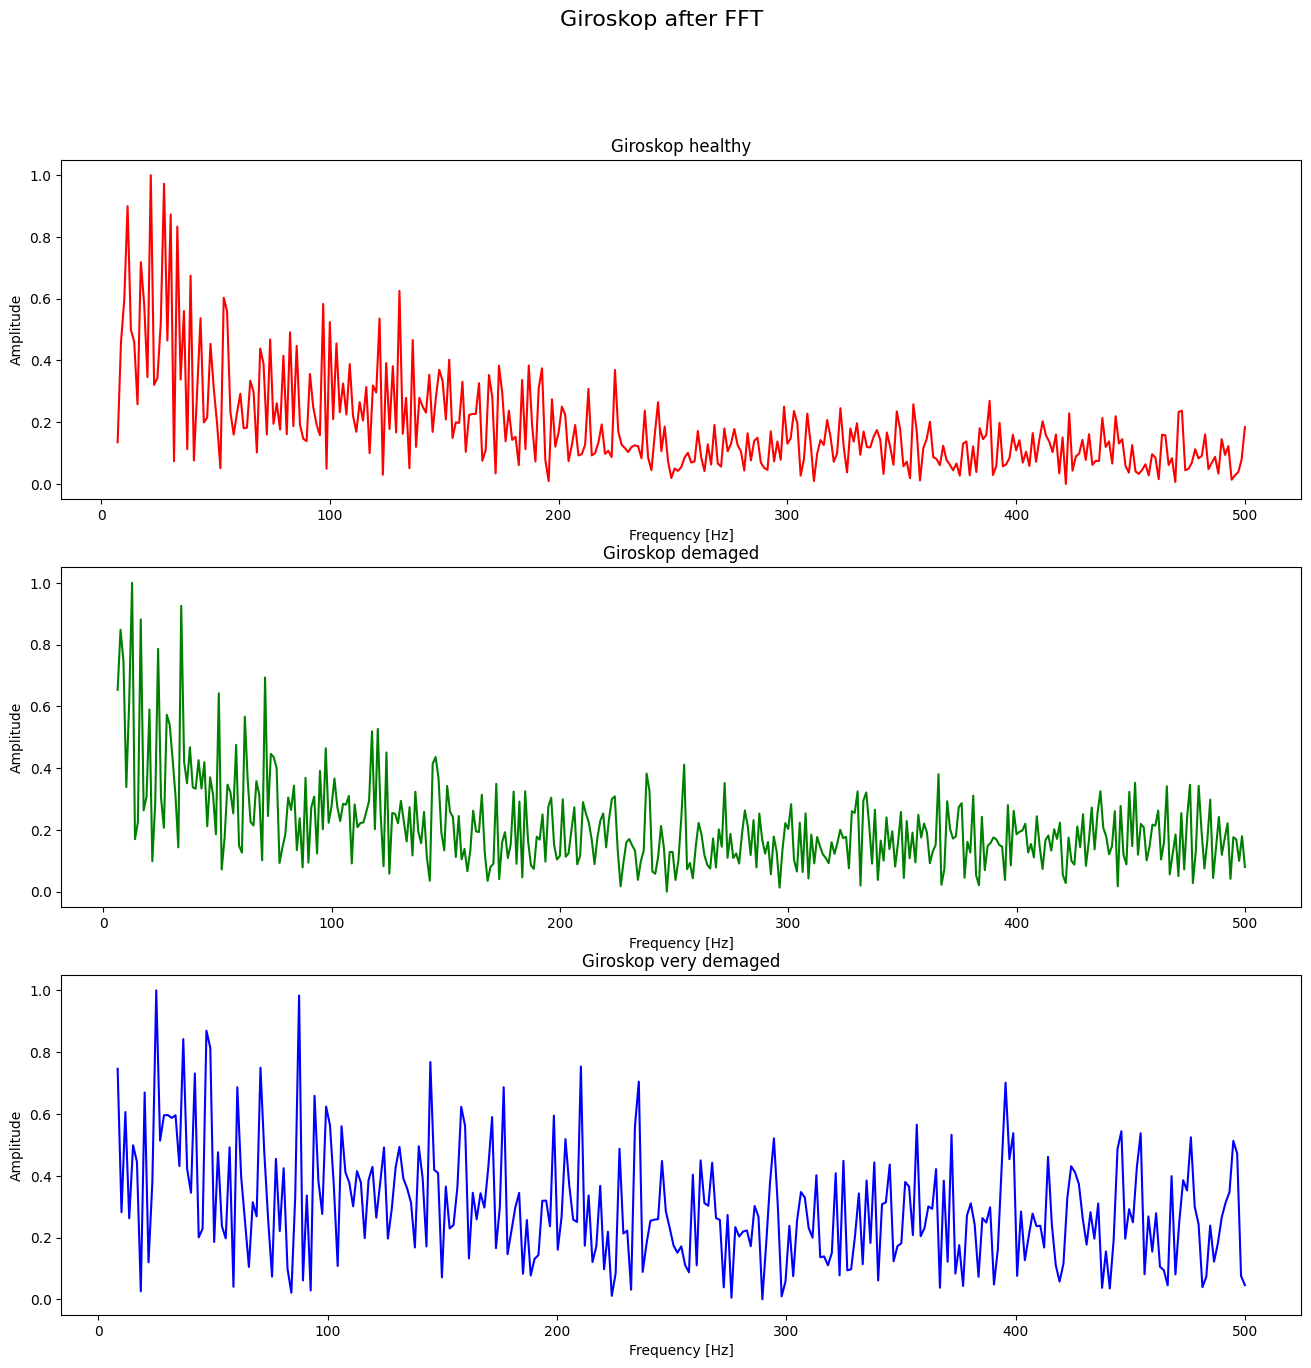

In [54]:
fft_val_h = abs(rfft(gyro_healthy[50:len(gyro_healthy)-210]))
fft_freq_h = rfftfreq(len(gyro_healthy[50:len(gyro_healthy)-210]),d=1/1000)

fft_val_d = abs(rfft(gyro_damaged[50:len(gyro_damaged)-190]))
fft_freq_d = rfftfreq(len(gyro_damaged[50:len(gyro_damaged)-190]),d=1/1000)

fft_val_vd = abs(rfft(gyro_very_damaged[50:len(gyro_very_damaged)-135]))
fft_freq_vd = rfftfreq(len(gyro_very_damaged[50:len(gyro_very_damaged)-135]),d=1/1000)

fig,ax = plt.subplots(3,1,figsize=[16,15])
ax[0].set_title('Giroskop after FFT')
ax[0].plot(fft_freq_h[5:], normalization(fft_val_h[5:]), label='gyro_healthy',color='red')
ax[1].plot(fft_freq_d[5:], normalization(fft_val_d[5:]), label='gyro_damaged',color='green')
ax[2].plot(fft_freq_vd[5:],normalization(fft_val_vd[5:]),label='gyro_very_damaged',color='blue')
ax[0].set_title('Giroskop healthy')
ax[1].set_title('Giroskop demaged')
ax[2].set_title('Giroskop very demaged')
fig.suptitle('Giroskop after FFT', fontsize=16)
ax[0].set_ylabel('Amplitude')
ax[1].set_ylabel('Amplitude')
ax[2].set_ylabel('Amplitude')

ax[0].set_xlabel('Frequency [Hz]')
ax[1].set_xlabel('Frequency [Hz]')
ax[2].set_xlabel('Frequency [Hz]')
plt.show()

In [55]:
gyro_healthy_split = split_array(gyro_healthy[50:len(gyro_healthy)-210],150,125)
gyro_damaged_split = split_array(gyro_damaged[50:len(gyro_damaged)-190],150,125)
gyro_very_damaged_split = split_array(gyro_very_damaged[50:len(gyro_very_damaged)-135],150,125)

---
Save gyroscope data in the frequency domain.

In [56]:
df_gyro_healthy = FFT_data(gyro_healthy_split)
df_gyro_damaged = FFT_data(gyro_damaged_split)
df_gyro_very_damaged = FFT_data(gyro_very_damaged_split)

df_gyro_healthy.to_csv('data_preprocesed/gyro_healthy_samples.csv')
df_gyro_damaged.to_csv('data_preprocesed/gyro_damaged_samples.csv')
df_gyro_very_damaged.to_csv('data_preprocesed/gyro_very_damaged_samples.csv')

In [57]:
df_gyro_healthy.head()

,Frequencies,Sample 1,Sample 2,Sample 3,Sample 4,Sample 5,Sample 6,Sample 7,Sample 8,Sample 9,...,Sample 13,Sample 14,Sample 15,Sample 16,Sample 17,Sample 18,Sample 19,Sample 20,Sample 21,Sample 22
0,20.0,0.291723,0.290193,0.330553,0.776665,0.739334,1.000000,0.664665,1.000000,0.756309,...,0.105586,0.135824,0.093886,0.382420,0.815579,0.628975,0.477697,0.831335,1.000000,0.864211
1,22.0,0.587173,0.727546,0.907014,0.648258,1.000000,0.692805,1.000000,0.641000,1.000000,...,0.572763,0.636288,0.436058,0.621409,0.584903,0.748181,0.405310,0.947133,0.772675,1.000000
2,24.0,0.775388,0.590265,0.912820,0.686112,0.869195,0.602269,0.978140,0.401656,0.701249,...,0.772114,1.000000,0.438338,0.368709,0.816103,0.716633,0.523035,1.000000,0.759741,0.717753
3,26.0,0.740052,0.314294,0.309763,0.568411,0.698073,0.643005,0.621538,0.236465,0.210012,...,0.678423,0.953063,0.547446,0.543409,1.000000,0.695731,0.733132,0.973192,0.851775,0.611819
4,28.0,0.935007,0.815733,0.455119,0.449102,0.834688,0.749689,0.351808,0.051400,0.499509,...,0.569184,0.615203,0.975907,0.956191,0.967256,0.843622,0.940294,0.951584,0.884213,0.928611


[]

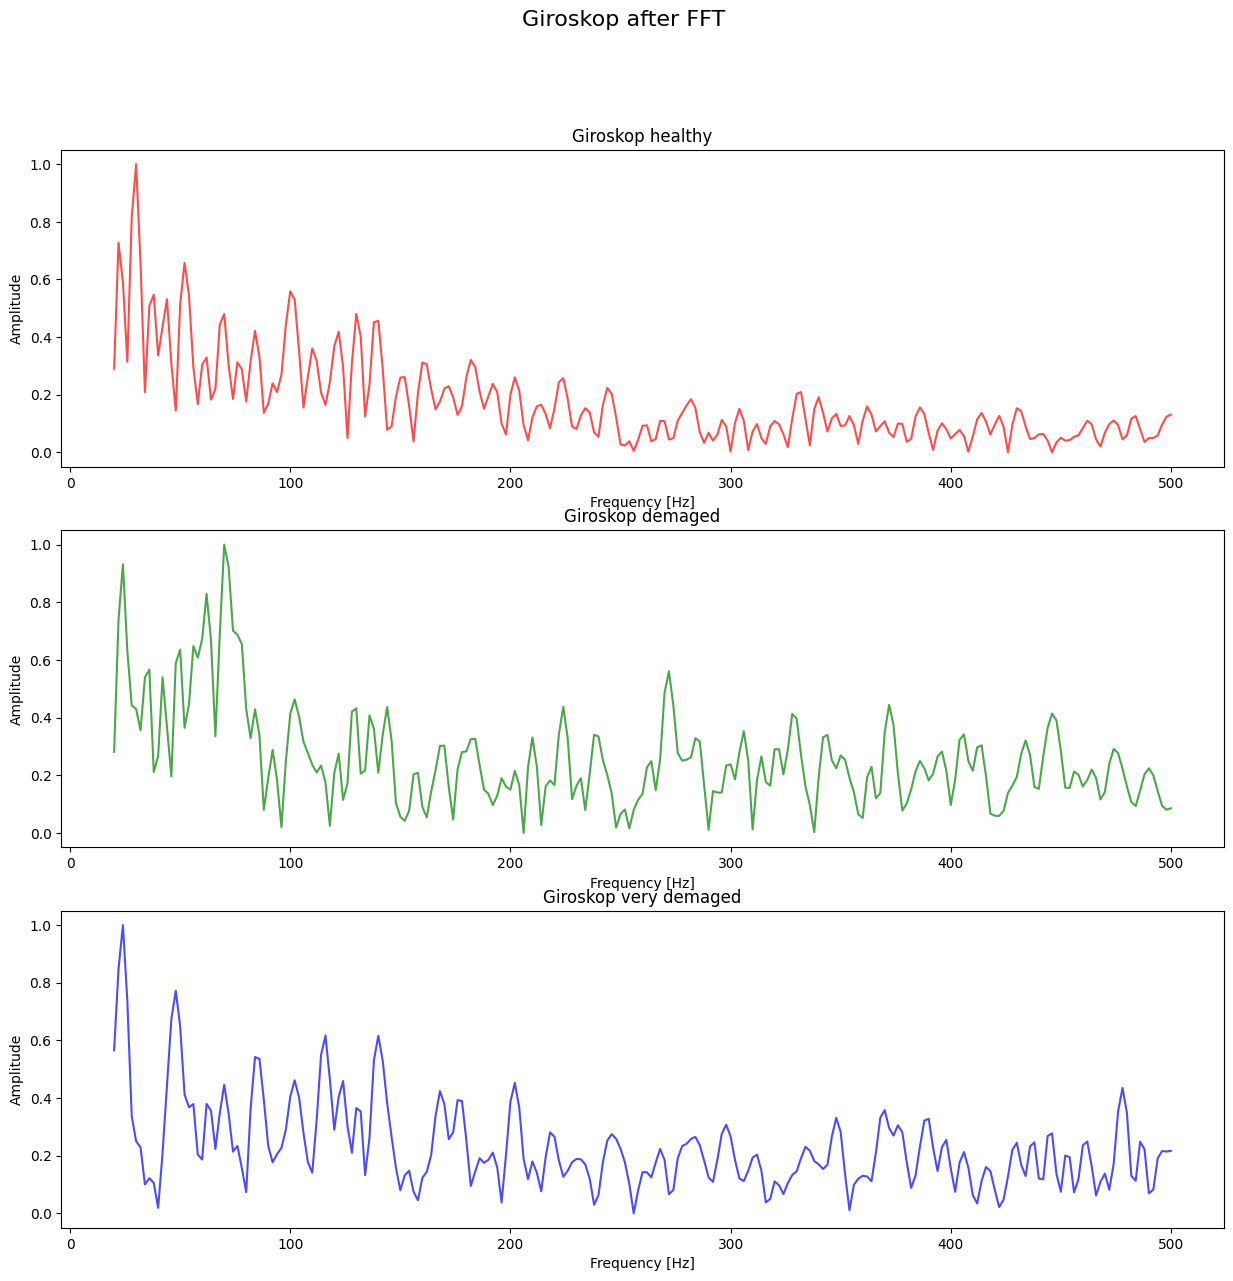

In [58]:
freq = df_gyro_healthy['Frequencies']
samples_1 = [x for x in df_gyro_healthy.columns if 'Sample' in x]
samples_2 = [x for x in df_gyro_damaged.columns if 'Sample' in x]
samples_3 = [x for x in df_gyro_very_damaged.columns if 'Sample' in x]

fig,ax = plt.subplots(3,1,figsize=[15,14])
for col in samples_1[1:2]:
    ax[0].plot(freq,df_gyro_healthy[col],alpha = 0.7, color='red')
    ax[0].set_title('Giroskop healthy')
for col in samples_2[1:2]:
    ax[1].plot(freq,df_gyro_damaged[col],alpha = 0.7, color='green')
    ax[1].set_title('Giroskop demaged')
for col in samples_3[1:2]:
    ax[2].plot(freq,df_gyro_very_damaged[col],alpha = 0.7, color='blue')
    ax[2].set_title('Giroskop very demaged')
    
ax[0].set_ylabel('Amplitude')
ax[1].set_ylabel('Amplitude')
ax[2].set_ylabel('Amplitude')

ax[0].set_xlabel('Frequency [Hz]', fontsize=10)
ax[1].set_xlabel('Frequency [Hz]', fontsize=10)
ax[2].set_xlabel('Frequency [Hz]', fontsize=10)
fig.suptitle('Giroskop after FFT', fontsize=16)

plt.plot()

In [59]:
gyro_agg_healthy_split = split_aggregation(gyro_healthy[50:len(gyro_healthy)-210],125,25)
gyro_agg_damaged_split = split_aggregation(gyro_damaged[50:len(gyro_damaged)-190],125,25)
gyro_agg_very_damaged_split = split_aggregation(gyro_very_damaged[50:len(gyro_very_damaged)-135],125,25)

---
Save gyroscope data in the frequency domain, but it has aggregated data from previous.


In [60]:
df_gyro_agg_healthy = FFT_data(gyro_agg_healthy_split)
df_gyro_agg_damaged = FFT_data(gyro_agg_damaged_split)
df_gyro_agg_very_damaged = FFT_data(gyro_agg_very_damaged_split)
df_gyro_agg_healthy.to_csv('data_preprocesed/gyro_agg_healthy_samples.csv')
df_gyro_agg_damaged.to_csv('data_preprocesed/gyro_agg_damaged_samples.csv')
df_gyro_agg_very_damaged.to_csv('data_preprocesed/gyro_agg_very_damaged_samples.csv')

In [65]:
df_gyro_agg_healthy.head()

,Frequencies,Sample 1,Sample 2,Sample 3,Sample 4,Sample 5,Sample 6,Sample 7,Sample 8,Sample 9,...,Sample 14,Sample 15,Sample 16,Sample 17,Sample 18,Sample 19,Sample 20,Sample 21,Sample 22,Sample 23
0,20.0,1.000000,0.291723,0.990856,0.154706,0.892491,0.332129,0.817784,0.486697,0.785491,...,0.374143,0.646413,0.594604,0.594604,0.594604,0.594604,0.594604,0.594604,0.594604,0.594604
1,22.0,0.898316,0.587173,0.701461,0.599560,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,0.902274,0.902274,0.902274,0.902274,0.902274,0.902274,0.902274,0.902274
2,24.0,0.591674,0.775388,0.111563,0.527578,0.363623,0.679586,0.373966,0.469347,0.416258,...,0.089599,0.338311,0.457623,0.457623,0.457623,0.457623,0.457623,0.457623,0.457623,0.457623
3,26.0,0.449963,0.740052,0.212512,0.291204,0.208262,0.487992,0.204459,0.271046,0.272988,...,0.168147,0.347081,0.349061,0.349061,0.349061,0.349061,0.349061,0.349061,0.349061,0.349061
4,28.0,0.574103,0.935007,0.544762,0.055050,0.477765,0.649506,0.418330,0.279336,0.431768,...,0.417102,0.605582,0.887777,0.887777,0.887777,0.887777,0.887777,0.887777,0.887777,0.887777


In [62]:
df_gyro_agg_healthy.get('Frequencies')

0       20.0
1       22.0
2       24.0
3       26.0
4       28.0
       ...  
236    492.0
237    494.0
238    496.0
239    498.0
240    500.0
Name: Frequencies, Length: 241, dtype: float64

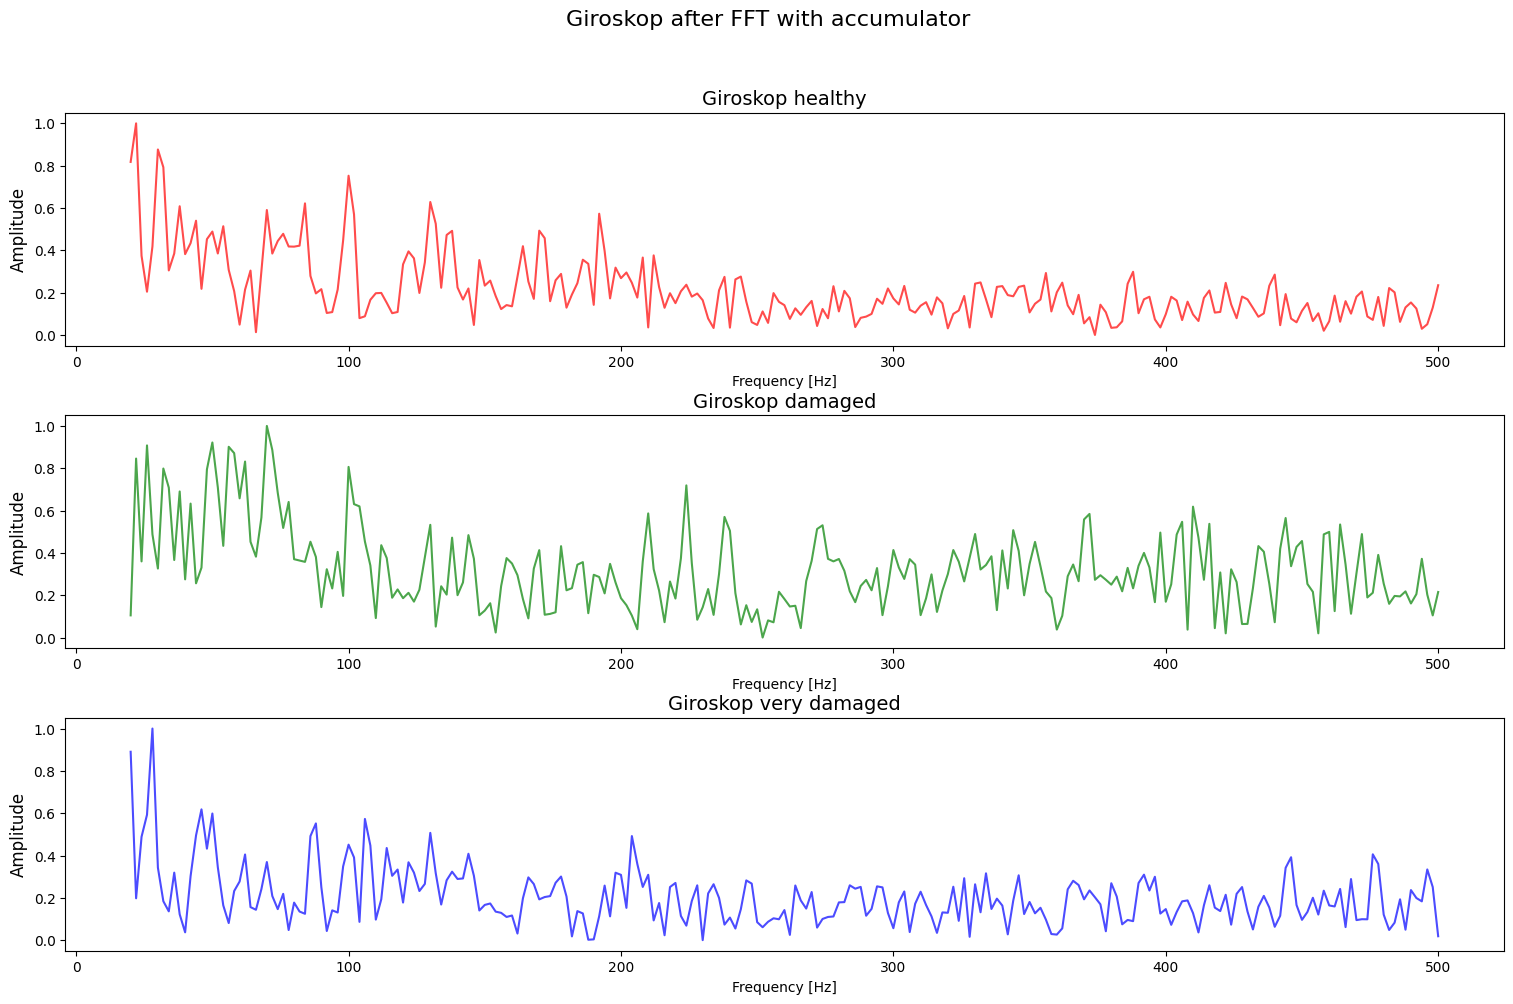

In [68]:
freq = df_gyro_agg_healthy['Frequencies']

samples_1 = [x for x in df_gyro_agg_healthy.keys() if 'Sample' in x]
samples_2 = [x for x in df_gyro_agg_damaged.keys() if 'Sample' in x]
samples_3 = [x for x in df_gyro_agg_very_damaged.keys() if 'Sample' in x]


fig, ax = plt.subplots(3, 1, figsize=[15, 10])  

for col in samples_1[6:7]:
    ax[0].plot(freq, df_gyro_agg_healthy[col], alpha=0.7, color='red')
    ax[0].set_title('Giroskop healthy', fontsize=14)

for col in samples_2[6:7]:
    ax[1].plot(freq, df_gyro_agg_damaged[col], alpha=0.7, color='green')
    ax[1].set_title('Giroskop damaged', fontsize=14)

for col in samples_3[6:7]:
    ax[2].plot(freq, df_gyro_agg_very_damaged[col], alpha=0.7, color='blue')
    ax[2].set_title('Giroskop very damaged', fontsize=14)

fig.suptitle('Giroskop after FFT with accumulator', fontsize=16)

fig.tight_layout(rect=[0, 0, 1, 0.95])
fig.subplots_adjust(hspace=0.3)

ax[0].set_ylabel('Amplitude', fontsize=12)
ax[1].set_ylabel('Amplitude', fontsize=12)
ax[2].set_ylabel('Amplitude', fontsize=12)

ax[0].set_xlabel('Frequency [Hz]', fontsize=10)
ax[1].set_xlabel('Frequency [Hz]', fontsize=10)
ax[2].set_xlabel('Frequency [Hz]', fontsize=10)
plt.savefig('photos/gyro_fft_500_1.png')
plt.show()

